# ML4EO - Team 2

> Summer School in Pavia, 2023.06.05. - 2023.06.09.

This is the notebook for the BIP course Machine Learning for Earth Observation. The members of Team 2 are the following:

- Team Lead: Jules Bourcier
- Dario Perregrini
- Patricia Camparada
- Olivér Angyal

## Topic

Monitoring the water extents of the Po River flowing south of Cremona during Spring-Summer 2022 (the lack of precipitations and the severe drought resulted in a big reduction of the water content in the river, down by more to -8 m w.r.t. the usual level).

> Team specific task: monitoring water extents with **multispectral sensors**

## Datasets


In [2]:
import pandas as pd
import numpy as np

### Ancillary data


In [3]:
!pip install --no-cache-dir torch torchvision --quiet
!pip install gdown --quiet
!gdown 1m3oRkElw3WGTwfrHbnD2iQKXz-FlfIga # ancillary data

Downloading...
From: https://drive.google.com/uc?id=1m3oRkElw3WGTwfrHbnD2iQKXz-FlfIga
To: /Users/oliverangyal/Development/bip-ml4eo/src/Cremona SIAP - Livello Idrometrico - 2023-01-12.csv
100%|████████████████████████████████████████| 309k/309k [00:00<00:00, 4.30MB/s]


In [4]:
ancillary_data_path = "/Users/oliverangyal/Development/bip-ml4eo/Cremona SIAP - Livello Idrometrico - 2023-01-12.csv"

ancillary_df = pd.read_csv(ancillary_data_path, sep=";")
ancillary_df.rename(
    columns={
        "Orario": "Hours",
        "Cremona SIAP - Livello Idrometrico - 15970 (m)": "Hydrometric level",
        "Variazione": "Variation",
        "Valore assoluto": "Absolute value",
    },
    inplace=True,
)
ancillary_df.head()

,Hours,Hydrometric level,Variation,Absolute value
0,2022-01-12 01:00,-6.64,NaN,-6.64
1,2022-01-12 02:00,-6.64,0.00,-6.64
2,2022-01-12 03:00,-6.64,0.00,-6.64
3,2022-01-12 04:00,-6.65,-0.01,-6.65
4,2022-01-12 05:00,-6.65,0.00,-6.65


In [5]:
print(f"Number of data points: {len(ancillary_df)}")

Number of data points: 8778


In [6]:
ancillary_df["Hours"] = pd.to_datetime(ancillary_df["Hours"])
ancillary_df.sort_values("Hours", inplace=True)

In [7]:
timestamp_s = ancillary_df["Hours"].map(pd.Timestamp.timestamp)
ancillary_df["Timestamp_s"] = timestamp_s

In [120]:
day = 24 * 60 * 60
month = (365.2425 / 12) * day
year = (365.2425) * day

ancillary_df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
ancillary_df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
ancillary_df["Month sin"] = np.sin(timestamp_s * (2 * np.pi / month))
ancillary_df["Month cos"] = np.cos(timestamp_s * (2 * np.pi / month))
ancillary_df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
ancillary_df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

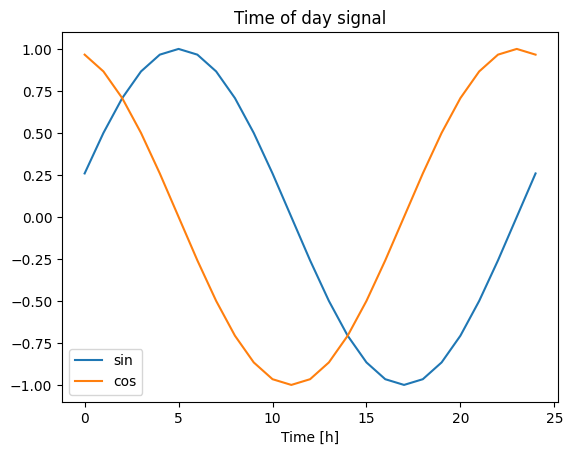

In [122]:
import matplotlib.pyplot as plt

plt.plot(np.array(ancillary_df["Day sin"])[:25])
plt.plot(np.array(ancillary_df["Day cos"])[:25])
plt.legend(["sin", "cos"])
plt.xlabel("Time [h]")
plt.title("Time of day signal")

In [10]:
ancillary_df["Hydrometric level"] = ancillary_df["Hydrometric level"].replace(
    "", np.nan
)
ancillary_df.loc[ancillary_df["Hydrometric level"] == "-", "Hydrometric level"] = np.nan
ancillary_df["Hydrometric level"] = ancillary_df["Hydrometric level"].astype(float)

In [11]:
print(
    "Hydrometric level missing values: ",
    ancillary_df["Hydrometric level"].isnull().sum(),
)

Hydrometric level missing values:  78


In [12]:
ancillary_df.loc[ancillary_df["Variation"] == "-", "Variation"] = np.nan
ancillary_df["Variation"] = ancillary_df["Variation"].astype(float)

In [13]:
print("Variation missing values: ", ancillary_df["Variation"].isnull().sum())

Variation missing values:  91


In [14]:
ancillary_df["Absolute value"] = ancillary_df["Absolute value"].abs()
print("Absolute value missing values: ", ancillary_df["Absolute value"].isnull().sum())

Absolute value missing values:  78


<AxesSubplot: xlabel='Hours'>

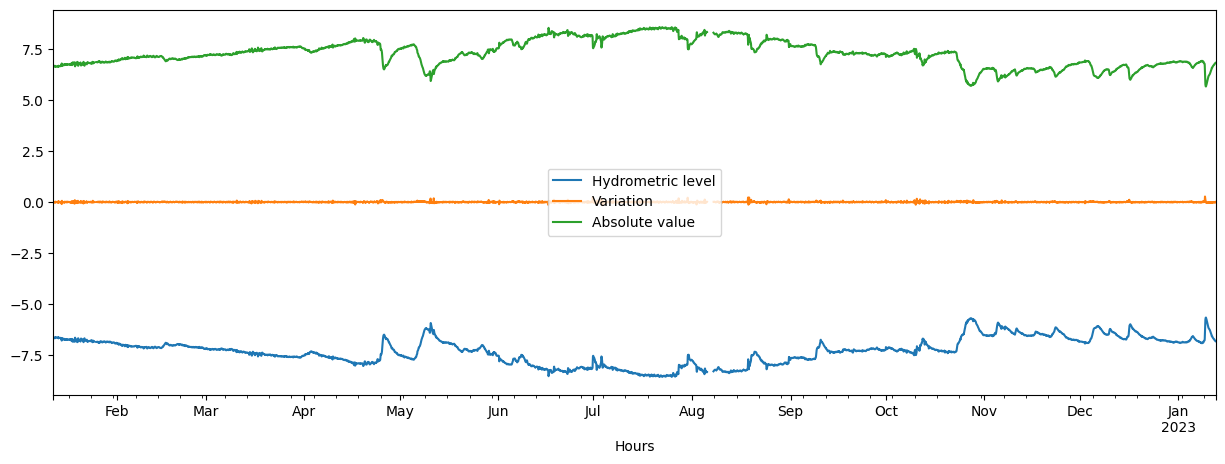

In [15]:
ancillary_df[["Hours", "Hydrometric level", "Variation", "Absolute value"]].set_index(
    "Hours"
).plot(figsize=(15, 5))

- little spikes are probably rain events?
- from June to September, the water level is the lowest


In [16]:
# get mean, min, max, for hydrometric level
ancillary_df["Hydrometric level"].describe()

count    8700.000000
mean       -7.309478
std         0.637510
min        -8.590000
25%        -7.770000
50%        -7.280000
75%        -6.850000
max        -5.670000
Name: Hydrometric level, dtype: float64

<AxesSubplot: >

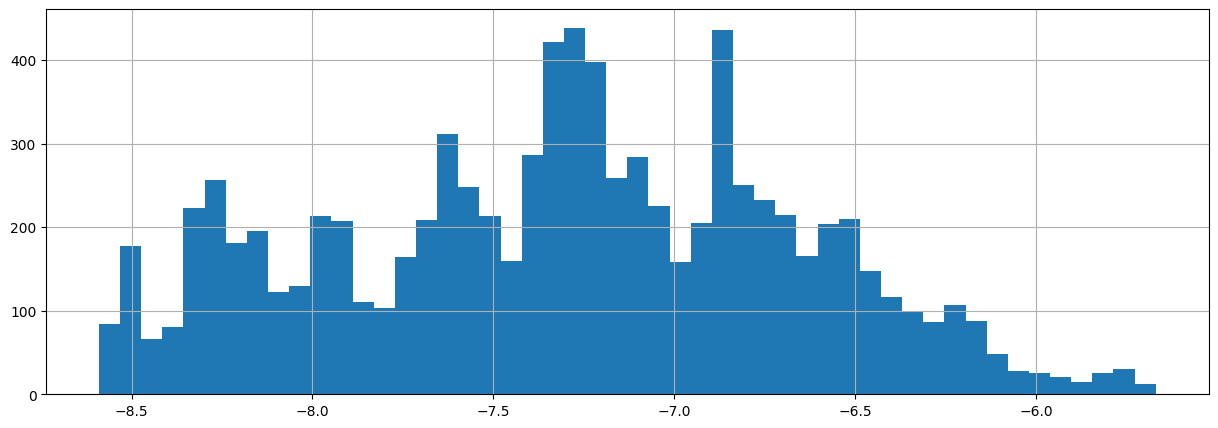

In [17]:
ancillary_df["Hydrometric level"].hist(bins=50, figsize=(15, 5))

In [62]:
ancillary_df["Variation"].describe()

count    8687.000000
mean       -0.000024
std         0.018291
min        -0.160000
25%        -0.010000
50%         0.000000
75%         0.010000
max         0.270000
Name: Variation, dtype: float64

<AxesSubplot: >

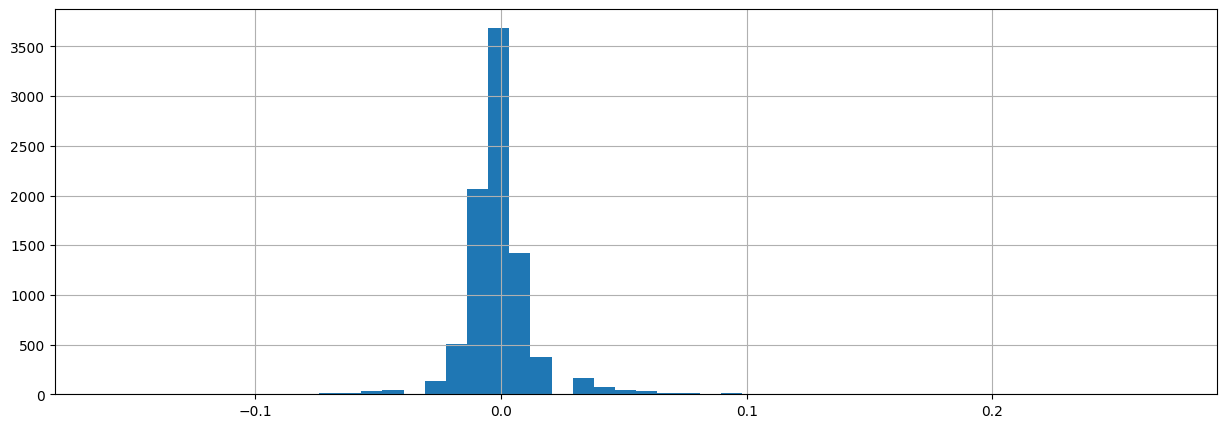

In [20]:
# variation distribution
ancillary_df["Variation"].hist(bins=50, figsize=(15, 5))

### Sentinel-2

Multispectral data in the period of interest.

The list of bands [[Source]](https://hatarilabs.com/ih-en/how-many-spectral-bands-have-the-sentinel-2-images):

| Bands                         | Central Wavelength (µm) | Resolution (m) |
| ----------------------------- | ----------------------- | -------------- |
| Band 1 - Coastal aerosol      | 0.443                   | 60             |
| Band 2 - Blue                 | 0.490                   | 10             |
| Band 3 - Green                | 0.560                   | 10             |
| Band 4 - Red                  | 0.665                   | 10             |
| Band 5 - Vegetation Red Edge  | 0.705                   | 20             |
| Band 6 - Vegetation Red Edge  | 0.740                   | 20             |
| Band 7 - Vegetation Red Edge  | 0.783                   | 20             |
| Band 8 - NIR                  | 0.842                   | 10             |
| Band 8A - Vegetation Red Edge | 0.865                   | 20             |
| Band 9 - Water vapour         | 0.945                   | 60             |
| Band 10 - SWIR - Cirrus       | 1.375                   | 60             |
| Band 11 - SWIR                | 1.610                   | 20             |
| Band 12 - SWIR                | 2.190                   | 20             |

Filenames [Source](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/naming-convention):

`S2A_MSIL2A_20220309T100841_N0400_R02` means:

- "S2A": satellite used to capture the data (Sentinel-2A)
- "MSIL2A": denotes the Level-2A product level (atmospherically corrected Surface Reflectance (SR) images)
- "20220309T100841": the datatake sensing start time (March 9, 2022, at 10:08:41 UTC)
- "N0400": the Processing Baseline number
- "R02": Relative Orbit number (R001 - R143)

The images span from about 2022.03.07. to 2022.08.24.

The ancillary data spans from 2022.01.12. 01:00:00 to 2023.01.12. 18:00:00 (an entry every hour).


In [89]:
# meta info seems to be useless
sentinel_2_meta_path = (
    "/kaggle/input/sentinel-2-cremona/sentinel-2-cremona/S2_Cremona_DESCENDING_info.csv"
)

sentinel_2_meta_df = pd.read_csv(sentinel_2_meta_path)
sentinel_2_meta_df.head()

,system:index,.geo
0,20220307T101759_20220307T102247_T32TNR,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,20220307T101759_20220307T102247_T32TNQ,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,20220309T100841_20220309T101722_T32TNR,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,20220309T100841_20220309T101722_T32TNQ,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,20220322T101711_20220322T102531_T32TNR,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [133]:
import os
import rasterio
from typing import List, Tuple
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import numpy as np

from torchvision.transforms import Compose, ToTensor


class S2(Dataset):
    def __init__(
        self,
        root: str = "/kaggle/input/sentinel-2-cremona/sentinel-2-cremona",
        transform: Compose = Compose([ToTensor()]),
    ):
        self.root = os.path.join(root, "images")
        self.transform = transform
        self.files = self.load_files(self.root)
        self.bands = self.get_bands()
        self.readable_band_names = {
            "B2": "B2 - Blue",
            "B3": "B3 - Green",
            "B4": "B4 - Red",
            "B5": "B5 - Red Edge 1",
            "B6": "B6 - Red Edge 2",
            "B7": "B7 - Red Edge 3",
            "B8A": "B8A - NIR Narrow",
            "B8": "B8 - NIR Wide",
            "B11": "B11 - SWIR 1",
            "B12": "B12 - SWIR 2",
        }

    @staticmethod
    def load_files(root: str) -> List[str]:
        return os.listdir(root)

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, idx: int) -> torch.Tensor:
        file = self.files[idx]
        with rasterio.open(os.path.join(self.root, file)) as data:
            img = data.read()
            img = img.transpose(1, 2, 0)  # CHW
        x = self.transform(img)
        return x

    def get_bands(self) -> Tuple[str]:
        file = self.files[0]
        with rasterio.open(os.path.join(self.root, file)) as data:
            return data.descriptions

    def get_band_index(self, band_name):
        return self.bands.index(band_name)

    def plot_image(self, idx, band_name) -> None:
        colormap = None

        if band_name in ["B2", "B3", "B4"]:
            colormap = "viridis"
        elif band_name in ["B5", "B6", "B7"]:
            colormap = "pink"
        elif band_name in ["B8A", "B8"]:
            colormap = "gray"
        elif band_name in ["B11", "B12"]:
            colormap = "hot"

        band_idx = self.bands.index(band_name)

        img = self[idx]
        band = img[band_idx, :, :]

        plt.imshow(band, cmap=colormap)
        plt.axis("off")
        plt.title(f"{self.readable_band_names[band_name]}")
        plt.show()

In [134]:
dataset = S2()

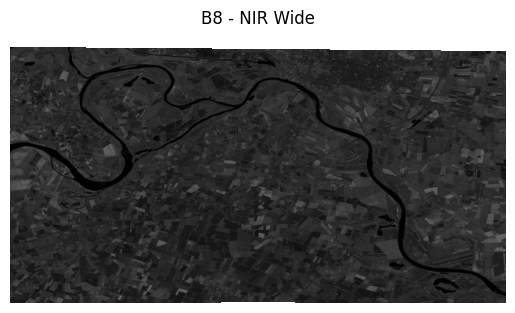

In [139]:
dataset.plot_image(0, "B8")

## Task 1

To extract the water extents as accurately as possible by classifying the data or by using water-related indexes.


## Task 2

To compute the total water surface extents statistics (histogram, mean, variance, max and min values) in the period of interest.


## Task 3

To find possible correlations between the measurements extracted from EO data and those on the ground.


## Task 4

To build a regression model for the water extent and/or water level measures for nowcasting purposes (i.e., forecasting at a very close time value).


For this task, we will perform supervised learning on the ancillary dataset containing hydrometric level measurements. We will investigate the following models:

- It is considered best practice to start with a persistence model in time series forecasting, which is a very naive model that predicts the next value to be the same as the current value. This is a good baseline to compare other models to.
- Next, we will try to improve on the persistence model by using a simple linear auto-regressive model...
- Finally, we will experiment with adding image features extracted from the period of interest and predicting the hydrometric level. (also check performance based on solely the image features) -> point is: with data fusion, we can improve the performance even further

Given the good performance of these simple models, it is not
maybe try an LSTM?


## Data analysis


In [63]:
ancillary_df["Hydrometric level"].describe()

count    8700.000000
mean       -7.309478
std         0.637510
min        -8.590000
25%        -7.770000
50%        -7.280000
75%        -6.850000
max        -5.670000
Name: Hydrometric level, dtype: float64

In [64]:
ancillary_df["Variation"].describe()

count    8687.000000
mean       -0.000024
std         0.018291
min        -0.160000
25%        -0.010000
50%         0.000000
75%         0.010000
max         0.270000
Name: Variation, dtype: float64

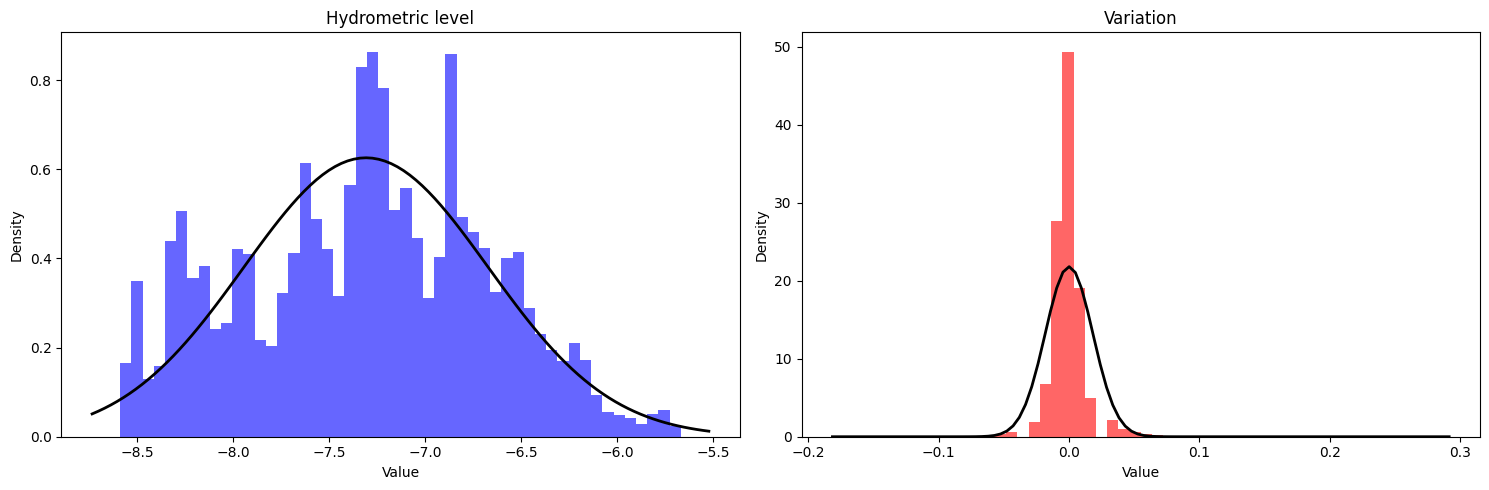

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# First subplot for "Hydrometric level"
mu1, std1 = (
    ancillary_df["Hydrometric level"].mean(),
    ancillary_df["Hydrometric level"].std(),
)  # mean and standard deviation
axs[0].hist(
    ancillary_df["Hydrometric level"], bins=50, density=True, color="b", alpha=0.6
)
xmin, xmax = axs[0].get_xlim()
x1 = np.linspace(xmin, xmax, 100)
p1 = norm.pdf(x1, mu1, std1)
axs[0].plot(x1, p1, "k", linewidth=2)
axs[0].set_title("Hydrometric level")
axs[0].set_xlabel("Value")
axs[0].set_ylabel("Density")

# Second subplot for "Variation"
mu2, std2 = (
    ancillary_df["Variation"].mean(),
    ancillary_df["Variation"].std(),
)  # mean and standard deviation
axs[1].hist(ancillary_df["Variation"], bins=50, density=True, color="r", alpha=0.6)
xmin, xmax = axs[1].get_xlim()
x2 = np.linspace(xmin, xmax, 100)
p2 = norm.pdf(x2, mu2, std2)
axs[1].plot(x2, p2, "k", linewidth=2)
axs[1].set_title("Variation")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Density")

plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area.
plt.show()

From the basic statistics we can see that the data is more or less normally distributed, and the variation is very low. We can see that the mean is very close to zero, and the standard deviation of the values is ~0.02 meaning that most of the time small changes happened to the water level (between hours). Furthermore, 75% of the values are less than or equal to 0.01.

Intuitively, this means that the water level does not change much per hour (usually less than 1 centimeter), with the greatest change being 0.027 meters, which is 2.7 centimeters.

Let us take a look at daily and monthly statistics and investigate the changes in mean and variance over time.


In [96]:
resample_df = ancillary_df.copy()

resample_df.index = pd.to_datetime(resample_df["Hours"])

# Resample to daily and calculate the mean
daily_df_mean = resample_df.resample("D").mean()
daily_df_variance = resample_df.resample("D").var()

# Resample to monthly and calculate the mean
monthly_df_mean = resample_df.resample("M").mean()
monthly_df_variance = resample_df.resample("M").var()

/var/folders/jt/3dr_0yh91s15rcc43pkynyqr0000gn/T/ipykernel_83787/3301080812.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_df_mean = resample_df.resample('D').mean()
/var/folders/jt/3dr_0yh91s15rcc43pkynyqr0000gn/T/ipykernel_83787/3301080812.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_df_variance = resample_df.resample('D').var()
/var/folders/jt/3dr_0yh91s15rcc43pkynyqr0000gn/T/ipykernel_83787/3301080812.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only o

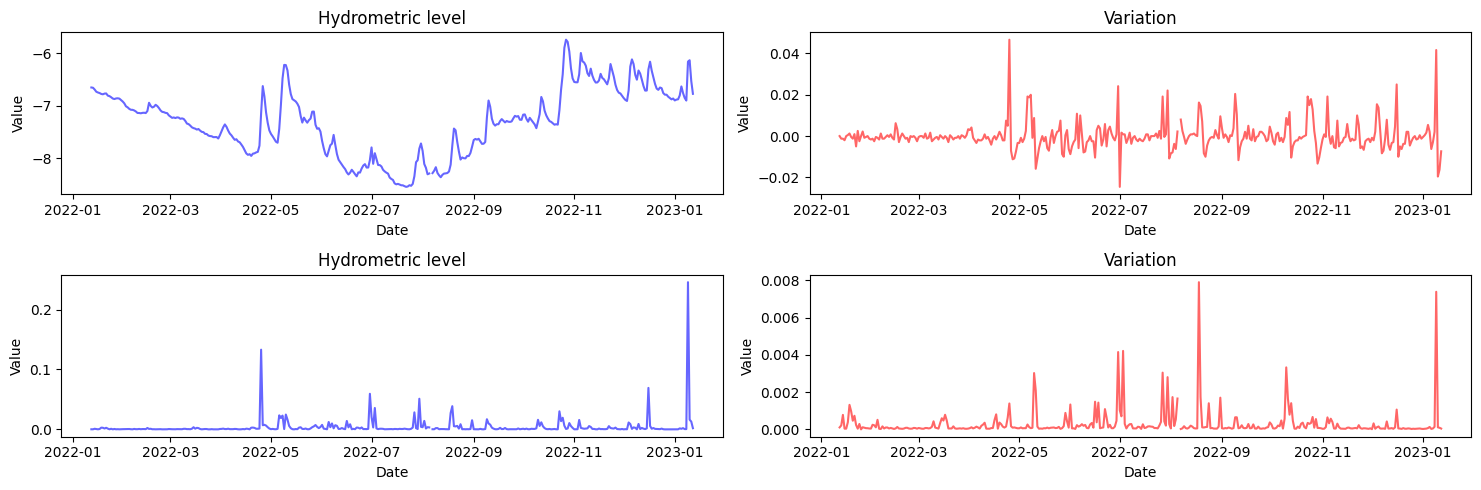

In [97]:
# plot changes in mean and variance for daily data

fig, axs = plt.subplots(2, 2, figsize=(15, 5))

axs[0, 0].plot(daily_df_mean["Hydrometric level"], color="b", alpha=0.6)
axs[0, 0].set_title("Hydrometric level")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Value")

axs[0, 1].plot(daily_df_mean["Variation"], color="r", alpha=0.6)
axs[0, 1].set_title("Variation")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Value")

axs[1, 0].plot(daily_df_variance["Hydrometric level"], color="b", alpha=0.6)
axs[1, 0].set_title("Hydrometric level")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Value")

axs[1, 1].plot(daily_df_variance["Variation"], color="r", alpha=0.6)
axs[1, 1].set_title("Variation")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Value")

plt.tight_layout()
plt.show()

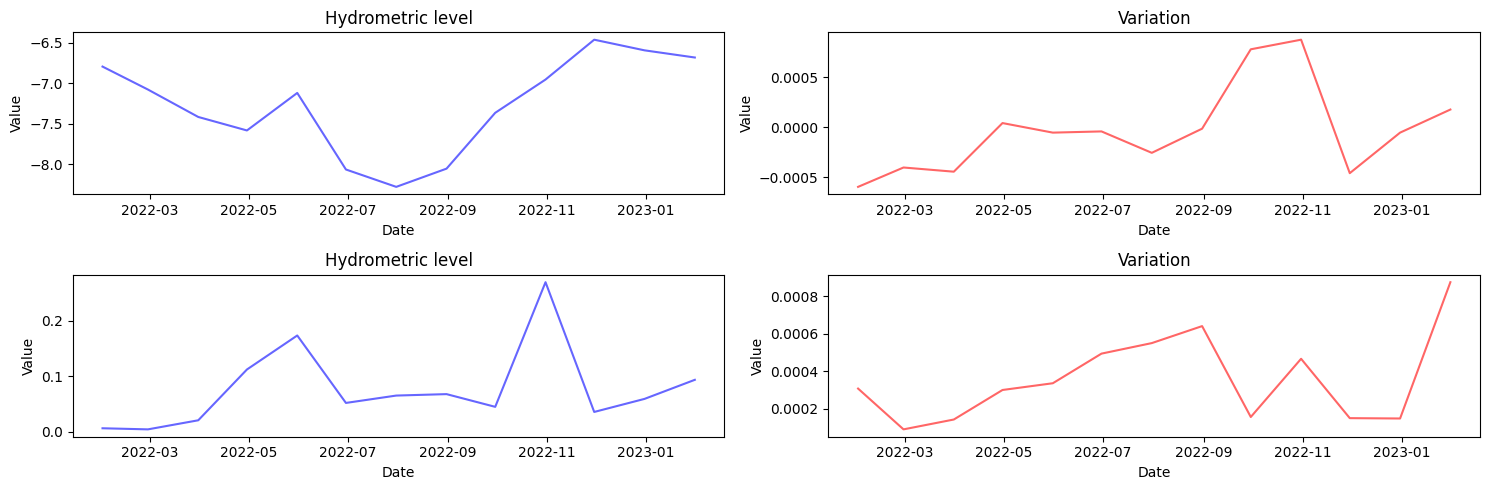

In [98]:
# plot changes in mean and variance for monthly data

fig, axs = plt.subplots(2, 2, figsize=(15, 5))

axs[0, 0].plot(monthly_df_mean["Hydrometric level"], color="b", alpha=0.6)
axs[0, 0].set_title("Hydrometric level")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Value")

axs[0, 1].plot(monthly_df_mean["Variation"], color="r", alpha=0.6)
axs[0, 1].set_title("Variation")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Value")

axs[1, 0].plot(monthly_df_variance["Hydrometric level"], color="b", alpha=0.6)
axs[1, 0].set_title("Hydrometric level")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Value")

axs[1, 1].plot(monthly_df_variance["Variation"], color="r", alpha=0.6)
axs[1, 1].set_title("Variation")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Value")

plt.tight_layout()
plt.show()

We can see however, that the mean and variance changed over time...

Seasonal decomposition: we investigate daily and monthly trends


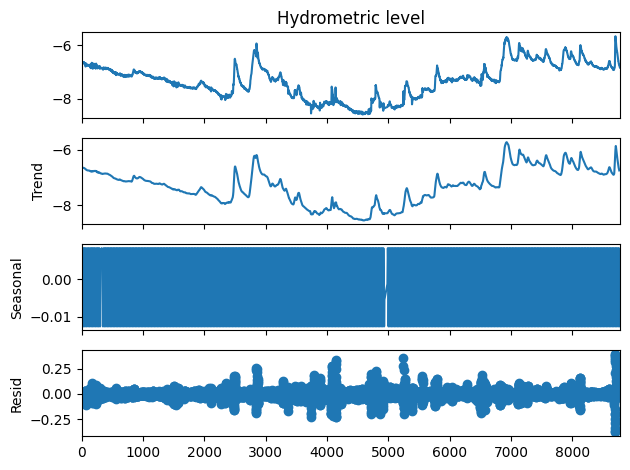

In [101]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

sd_df = ancillary_df.copy()

series = sd_df["Hydrometric level"].dropna()

result = seasonal_decompose(
    series, model="additive", period=24
)  # daily seasonality? period=24

result.plot()
plt.show()

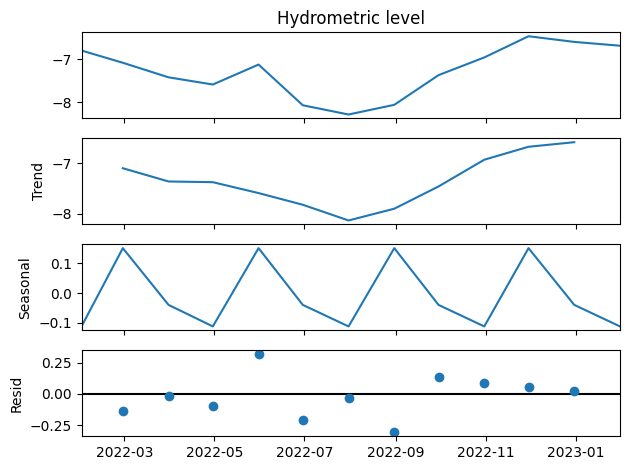

In [103]:
series = monthly_df_mean["Hydrometric level"]

result = seasonal_decompose(
    series, model="additive", period=3
)  # quarter year seasonality?

result.plot()
plt.show()

Let us investigate the periodicity in the data.


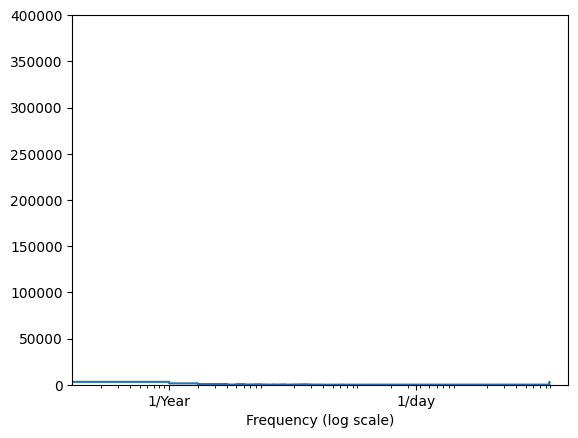

In [83]:
import torch
import numpy as np
import matplotlib.pyplot as plt

hydro_data = ancillary_df["Hydrometric level"].dropna().values

hydro_lvl = torch.from_numpy(hydro_data)

fft = torch.fft.fft(hydro_lvl)
fft_abs = np.abs(fft.numpy())
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(hydro_data)
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / (hours_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, fft_abs)
plt.xscale("log")
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=["1/Year", "1/day"])
_ = plt.xlabel("Frequency (log scale)")

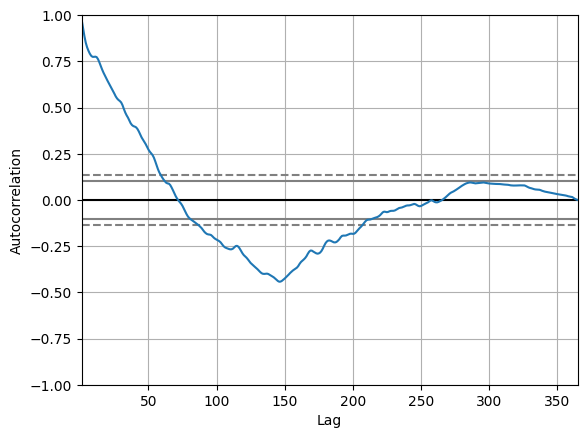

In [112]:
from pandas.plotting import autocorrelation_plot

# autocorrelation_plot(hydro_data) # hourly
autocorrelation_plot(daily_df_mean["Hydrometric level"].dropna().values)  # daily
# autocorrelation_plot(monthly_df_mean["Hydrometric level"].dropna().values) # monthly

# look at variation

plt.show()

We can see that there is a very strong autocorrelation at the lag of about 1 day and this decreases over time. This means that the water level is very similar from one day to the next, but the similarity decreases over time.


## Persistence model


       t-1     t
0      NaN -6.64
1    -6.64 -6.65
2    -6.65 -6.65
3    -6.65 -6.65
4    -6.65 -6.65
...    ...   ...
8671 -6.80 -6.82
8672 -6.82 -6.82
8673 -6.82 -6.83
8674 -6.83 -6.84
8675 -6.84 -6.84

[8676 rows x 2 columns]
Test MSE: 0.000
Test RMSE: 0.017
Test MAE: 0.009


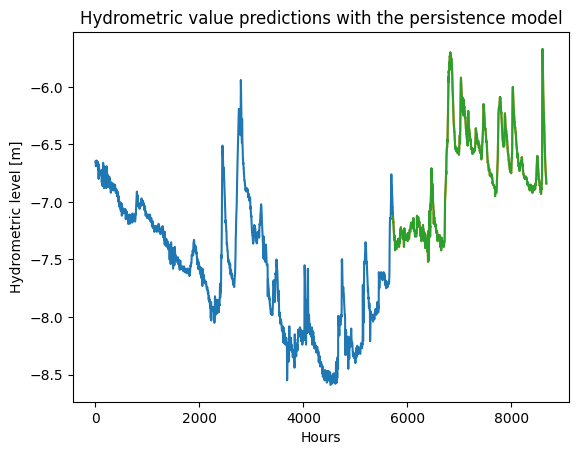

In [61]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot

series = dataset["Hydrometric level"]

values = pd.DataFrame(series.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ["t-1", "t"]
print(df)

# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:, 0], train[:, 1]
test_X, test_y = test[:, 0], test[:, 1]


# persistence model
def model_persistence(x):
    return x


# walk-forward validation
predictions = list()
for x in test_X:
    y_hat = model_persistence(x)
    predictions.append(y_hat)
rmse_test_score = mean_squared_error(test_y, predictions, squared=False)  # RMSE
mse_test_score = mean_squared_error(test_y, predictions)  # MSE
mae_test_score = mean_absolute_error(test_y, predictions)  # MAE
print("Test MSE: %.3f" % mse_test_score)
print("Test RMSE: %.3f" % rmse_test_score)
print("Test MAE: %.3f" % mae_test_score)

pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y])
pyplot.plot([None for i in train_y] + [x for x in predictions])
pyplot.title("Hydrometric value predictions with the persistence model")
plt.ylabel("Hydrometric level [m]")
plt.xlabel("Hours")
pyplot.show()

We set the baseline model to be a persistence model, which predicts the next value to be the same as the current one. We can see that because of the high autocorrelation in the data, this model performs quite well. However, other trends could exist in the data that are not captured by this model.


## Improvements


In [143]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

lagged_features = []
num_lags = 2

dataset = ancillary_df.copy()

for lag in range(1, num_lags + 1):
    feature_name = f"Lag{lag}"
    dataset[feature_name] = dataset["Hydrometric level"].shift(lag)
    lagged_features.append(feature_name)

# missing value handling strategy: dropping rows
dataset = dataset.dropna()

features = dataset[
    lagged_features
]  # ["Day sin", "Day cos", "Month sin", "Month cos", "Year sin", "Year cos"]]
# target = dataset["Hydrometric level"]
target = dataset["Variation"]

mse_scores = []
rmse_scores = []
mae_scores = []

k = 8
tscv = TimeSeriesSplit(gap=0, n_splits=k)
scaler = StandardScaler()

for train_index, test_index in tscv.split(features):
    # print(train_index, test_index)
    # print(train_index.shape, test_index.shape)
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LinearRegression()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

avg_mse = sum(mse_scores) / len(mse_scores)
print(f"Average Mean Squared Error: {avg_mse}")

avg_rmse = sum(rmse_scores) / len(rmse_scores)
print(f"Average Root Mean Squared Error: {avg_rmse}")

average_mae = sum(mae_scores) / len(mae_scores)
print(f"Average Mean Absolute Error: {average_mae}")

Average Mean Squared Error: 0.00022027636731327953
Average Root Mean Squared Error: 0.0146056100295428
Average Mean Absolute Error: 0.008684654870212584


With day, month, year

- Average Mean Squared Error: 0.0002840590641785781
- Average Root Mean Squared Error: 0.016524604672604214
- Average Mean Absolute Error: 0.010374351211708311

Without (just lags):

- Average Mean Squared Error: 0.00022978520117883432
- Average Root Mean Squared Error: 0.01501440123634222
- Average Mean Absolute Error: 0.00878550851400109


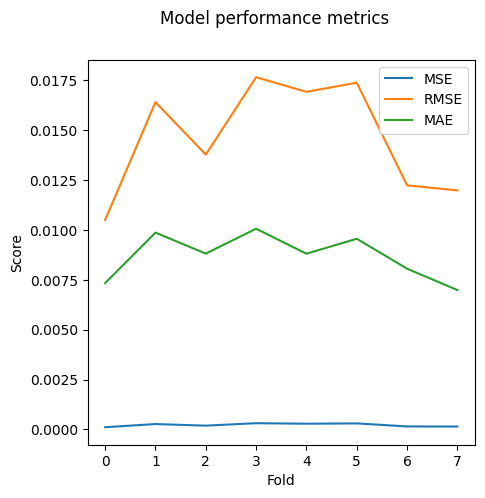

In [144]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.suptitle("Model performance metrics")

ax.plot(mse_scores, label="MSE")
ax.plot(rmse_scores, label="RMSE")
ax.plot(mae_scores, label="MAE")

plt.xlabel("Fold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

(964,) (964,)


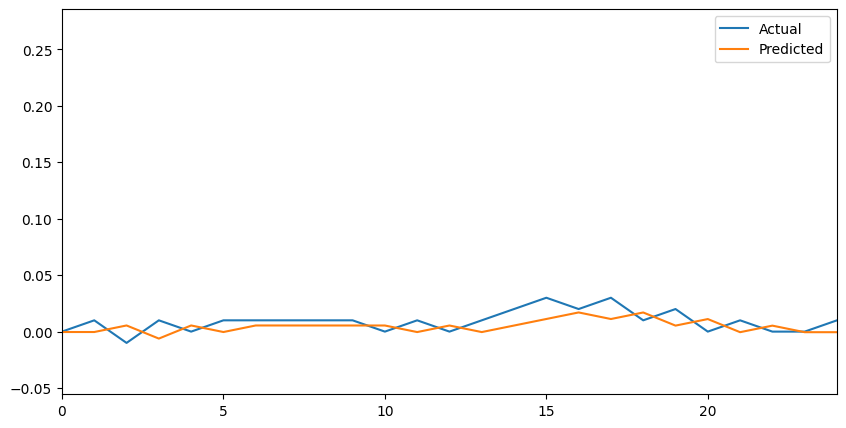

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
print(y_test.shape, y_pred.shape)
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.xlim(0, 24)
plt.legend()
plt.show()

- random walk process? -> done, no: we have changes over time in mean and variance, and there is a clear autocorrelation
- check more on the data basic stats -> done
- seasonal trends? -> needs a bit more interpretation, but quarterly could be interesting?
- Frequency analysis to uncover periodicities -> no entirely clear
- check if residuals are white noise -> if not, predictions can be still improved
- ARIMA?, LSTM?


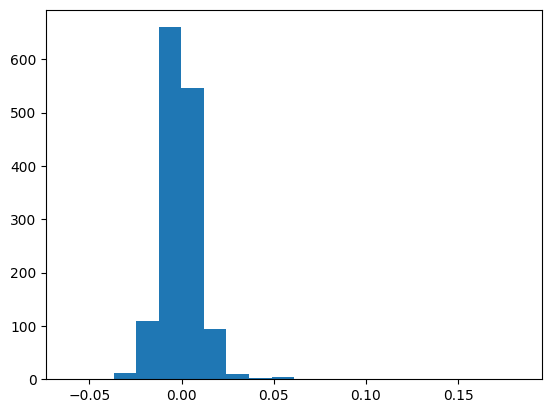

,0
count,1441.000000
mean,-0.000189
std,0.011763
min,-0.061197
25%,-0.006399
50%,-0.000610
75%,0.005268
max,0.183256


In [133]:
# check distribution of residuals

residuals = y_test.values - y_pred
plt.hist(residuals, bins=20)
plt.show()

# check if this is white noise

pd.DataFrame(residuals).describe()

### Feature importance


In [124]:
print(model.coef_)

importance = model.coef_

for i, coef in enumerate(importance):
    print(f"Feature {features.columns[i]}, Score: {coef}")

[ 3.43936640e-01 -3.44872506e-01 -1.03513047e-03  2.00028664e-04
 -1.61788907e-04  1.46153697e-04 -2.44399959e-04  7.14673048e-04]
Feature Lag1, Score: 0.3439366401103882
Feature Lag2, Score: -0.34487250587498136
Feature Day sin, Score: -0.0010351304671685805
Feature Day cos, Score: 0.000200028663678495
Feature Month sin, Score: -0.00016178890689275607
Feature Month cos, Score: 0.00014615369669016722
Feature Year sin, Score: -0.00024439995899304184
Feature Year cos, Score: 0.000714673048417578


### Cross-correlation


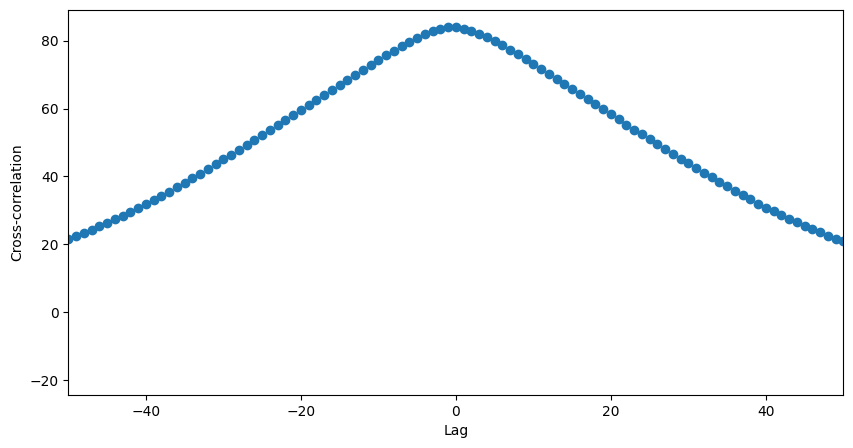

In [36]:
correlation = np.correlate(y_test - y_test.mean(), y_pred - y_pred.mean(), mode="full")

# Plot the cross-correlation
lags = np.arange(-len(y_test) + 1, len(y_test))
plt.figure(figsize=(10, 5))
plt.scatter(lags, correlation)
plt.ylabel("Cross-correlation")
plt.xlabel("Lag")
plt.xlim(-50, 50)
plt.show()

In [34]:
# find max lag
max_lag = lags[np.argmax(correlation)]
max_lag

0